In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [10, 5]

In [3]:
#header=None, sep=';'
yearly_df= pd.read_csv('Yearly Sunspots.csv', sep=',')

In [4]:
yearly_df.head()

,Date,Yearly Sunspot Number
0,1700/06,8.3
1,1701/06,18.3
2,1702/06,26.7
3,1703/06,38.3
4,1704/06,60.0


In [6]:
yearly_df.tail()

,Date,Yearly Sunspot Number
317,2017/06,21.7
318,2018/06,7.0
319,2019/06,3.6
320,2020/06,8.8
321,2021/06,29.6


In [7]:
yearly_df['Date']=pd.to_datetime(yearly_df['Date'])

In [8]:
yearly_df=yearly_df.set_index(['Date'])

In [9]:
yearly_df.head()

,Yearly Sunspot Number
Date,
1700-06-01,8.3
1701-06-01,18.3
1702-06-01,26.7
1703-06-01,38.3
1704-06-01,60.0


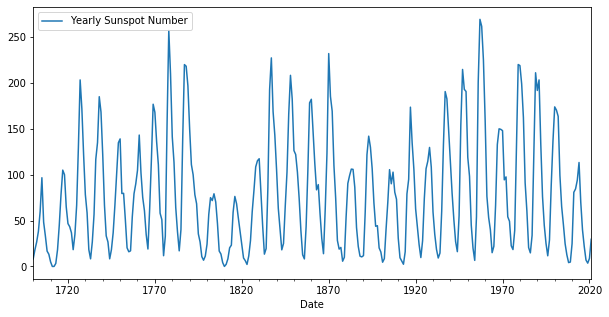

In [9]:
yearly_df.plot()

In [10]:
from statsmodels.tsa.stattools import adfuller

In [11]:
result= adfuller(yearly_df['Yearly Sunspot Number'].dropna())
print('p-value:', result[1])

p-value: 0.026067722399238793


In [12]:
dfoutput = pd.Series(result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in result[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Test Statistic                  -3.106612
p-value                          0.026068
#Lags Used                       8.000000
Number of Observations Used    313.000000
Critical Value (1%)             -3.451416
Critical Value (5%)             -2.870819
Critical Value (10%)            -2.571714
dtype: float64


#### p-value> 0.05 indicates the time series is non-stationary

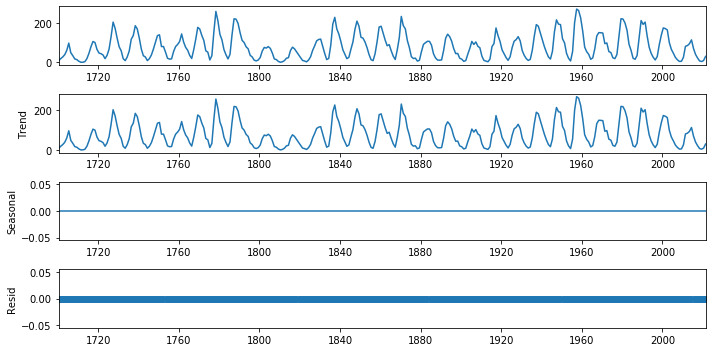

In [13]:
import statsmodels.api as sm

decomposition = sm.tsa.seasonal_decompose(yearly_df,model='additive')
fig = decomposition.plot()
plt.show()

## Differencing

In [15]:
from pmdarima.arima.utils import ndiffs

In [16]:
ndiffs(yearly_df['Yearly Sunspot Number'], test="adf")

0

### Time shift

In [17]:
yearly_df['Seasonal difference']=yearly_df['Yearly Sunspot Number']- yearly_df['Yearly Sunspot Number'].shift(11)

In [18]:
yearly_df.head()

,Yearly Sunspot Number,Seasonal difference
Date,,
1700-06-01,8.3,NaN
1701-06-01,18.3,NaN
1702-06-01,26.7,NaN
1703-06-01,38.3,NaN
1704-06-01,60.0,NaN


In [19]:
adfuller(yearly_df['Seasonal difference'].dropna())[1]

0.00023927052368609856

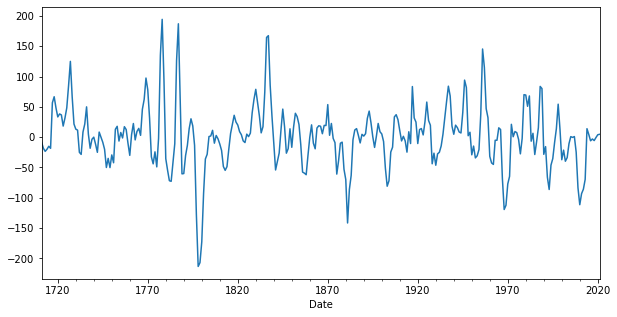

In [20]:
yearly_df['Seasonal difference'].dropna().plot()

####  After differencing once, the p-value<0.05

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

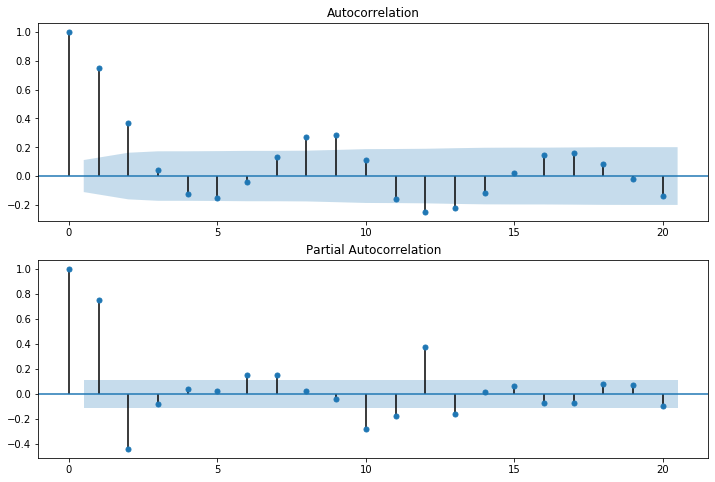

In [22]:
fig=plt.figure(figsize=(12,8))
ax1= fig.add_subplot(211)
fig=plot_acf(yearly_df['Seasonal difference'].dropna(),lags=20, ax=ax1)
ax2= fig.add_subplot(212)
fig=plot_pacf(yearly_df['Seasonal difference'].dropna(),lags=20, ax=ax2)

Till q=3, the autocorrelation is above 0.2 &
p=1 is significant

In [23]:
from scipy.signal import argrelextrema

In [24]:
lag_vals = np.arange(12*12)
autocorr_ser = np.array([yearly_df['Yearly Sunspot Number'].autocorr(lag=n) for n in lag_vals])
argrelextrema(autocorr_ser, np.less, order = 2)[0]
# we choose order = 2 because order = 1 gives two local maxima at lags = 125 and 128 months.

array([  5,  16,  27,  37,  48,  60,  71,  83,  94, 104, 115, 126, 137],
      dtype=int64)

In [25]:
ser = pd.Series(yearly_df['Yearly Sunspot Number'].values,index = yearly_df.index)

In [26]:
ser[argrelextrema(ser.values,np.less, order = 5)[0]]

Date
1723-06-01    18.3
1733-06-01     8.3
1744-06-01     8.3
1755-06-01    16.0
1766-06-01    19.0
1775-06-01    11.7
1784-06-01    17.0
1798-06-01     6.8
1810-06-01     0.0
1823-06-01     2.2
1833-06-01    13.4
1843-06-01    18.1
1856-06-01     8.2
1867-06-01    13.9
1878-06-01     5.7
1889-06-01    10.4
1901-06-01     4.6
1913-06-01     2.4
1923-06-01     9.7
1933-06-01     9.2
1944-06-01    16.1
1954-06-01     6.6
1964-06-01    15.0
1976-06-01    18.4
1986-06-01    14.8
1996-06-01    11.6
2008-06-01     4.2
2019-06-01     3.6
dtype: float64

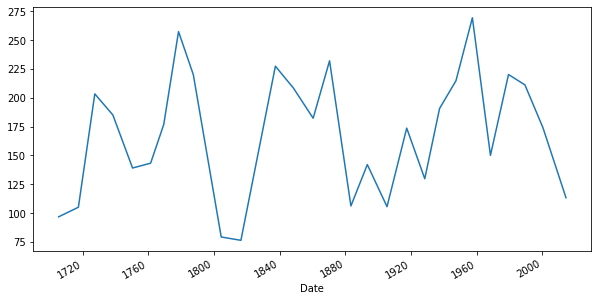

In [27]:
ser[argrelextrema(ser.values,np.greater, order = 7)[0]].plot()

## Model fitting

In [10]:
from statsmodels.tsa.arima_model import ARIMA 

In [11]:
dfp=yearly_df

In [74]:
df_train = dfp[:'2021-06-01']
df_test = dfp['2021-06-01':'2030-06-01']


In [61]:
model=ARIMA(df_train['Yearly Sunspot Number'], order=(7,0,1))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


In [89]:
arimaresult=model.fit()

In [90]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:               Yearly Sunspot Number   No. Observations:                  322
Model:             SARIMAX(7, 1, 1)x(7, 1, [], 11)   Log Likelihood               -1041.137
Date:                             Wed, 13 Jul 2022   AIC                           2114.275
Time:                                     19:50:46   BIC                           2169.003
Sample:                                 06-01-1700   HQIC                          2136.361
                                      - 06-01-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1076      0.063     17.592      0.000       0.984       1.231
ar.L2         -0.2292      0.085     -2.690      0.007      -0.396      -0.062
ar.L3         -0.2479      0.109     -2.271      0.023      -0.462      -0.034
ar.L4          0.0928      0.132      0.701      0.484      -0.167       0.352
ar.L5         -0.0653      0.126     -0.518      0.604      -0.312       0.182
ar.L6          0.0242      0.110      0.220      0.826      -0.191       0.239
ar.L7          0.0986      0.072      1.361      0.174      -0.043       0.241
ma.L1         -1.0000    108.044     -0.009      0.993    -212.762     210.762
ar.S.L11      -0.6541      0.075     -8.703      0.000      -0.801      -0.507
ar.S.L22      -0.4955      0.083     -6.002      0.000      -0.657      -0.334
ar.S.L33      -0.4062      0.089     -4.566      0.000      -0.581      -0.232
ar.S.L44      -0.3236      0.090     -3.609      0.000      -0.499      -0.148
ar.S.L55      -0.2317      0.089     -2.606      0.009      -0.406      -0.057
ar.S.L66      -0.2587      0.083     -3.106      0.002      -0.422      -0.095
ar.S.L77      -0.0905      0.071     -1.273      0.203      -0.230       0.049
sigma2       578.5993   6.25e+04      0.009      0.993   -1.22e+05    1.23e+05
===================================================================================
Ljung-Box (Q):                       49.07   Jarque-Bera (JB):                62.52
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               1.37   Skew:                             0.79
Prob(H) (two-sided):                  0.18   Kurtosis:                         5.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [64]:
dfp=yearly_df

In [75]:
len(df_test)

1

In [76]:
dfp['ARIMA']=result.predict(start=len(df_train),end=len(df_train)+22,dynamic=True)

In [91]:
A=arimaresult.predict(start=len(df_train),end=len(df_train)+22,dynamic=True)

In [66]:
import statsmodels.api as sm 
modelsarima=sm.tsa.statespace.SARIMAX(df_train['Yearly Sunspot Number'],
                                            order= (7,1,1),
                                           seasonal_order=(7,1,0,11),
                                           enforce_stationarity=False,
                                           enforce_invertibility=False)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


In [67]:
result=modelsarima.fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [77]:
dfp['SARIMA']=result.forecast(steps=22,dynamic=True)

In [82]:
s=result.forecast(steps=22,dynamic=True)

pandas.core.series.Series

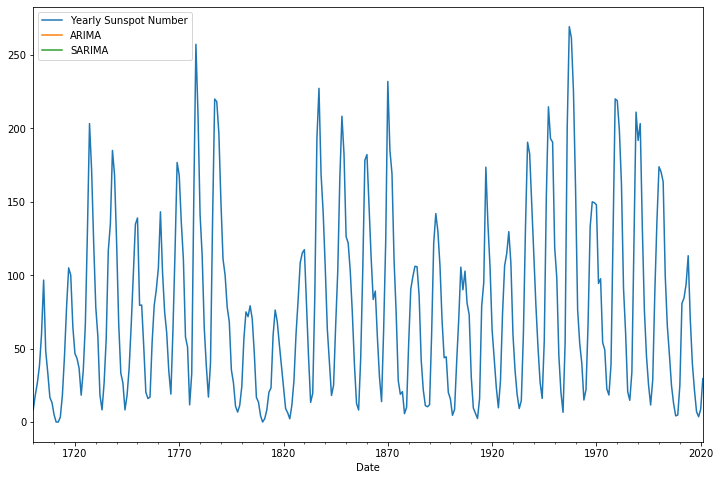

In [69]:
dfp[['Yearly Sunspot Number','ARIMA','SARIMA']].plot(figsize=(12,8))

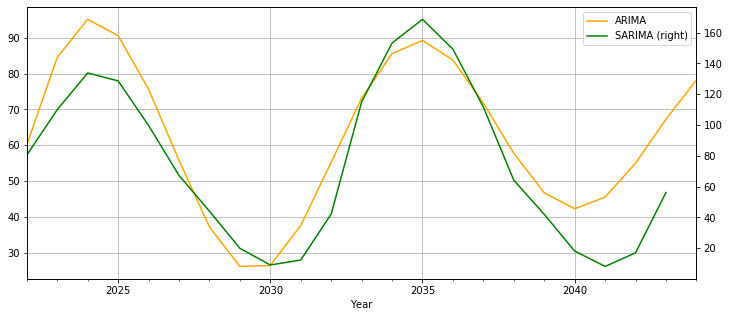

In [96]:
plt.figure(figsize=(12,5))
plt.xlabel('Year')

ax1 = A.plot(color='orange', grid=True, label='ARIMA')
ax2 = s.plot(color='green', grid=True, secondary_y=True, label='SARIMA')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()


plt.legend(h1+h2, l1+l2, loc='upper right')

plt.show()

In [ ]:
dfp['2009-06-01':'2019-06-01'][['Yearly Sunspot Number','ARIMA', 'SARIMA']].plot(figsize=(12,8))

### MAE

## 1997-2019

In [56]:
import sklearn.metrics
sklearn.metrics.mean_absolute_error(dfp['2009-06-01':'2019-06-01'][['Yearly Sunspot Number']], 
                                    dfp['2009-06-01':'2019-06-01'][['ARIMA']])

28.973813737440263

In [57]:
import sklearn.metrics
sklearn.metrics.mean_absolute_error(dfp['2009-06-01':'2019-06-01'][['Yearly Sunspot Number']], 
                                    dfp['2009-06-01':'2019-06-01'][['SARIMA']])

38.11928416235692

### RMSE

## 1997-2019

In [58]:
import numpy as np
np.sqrt(sklearn.metrics.mean_squared_error(dfp['2009-06-01':'2019-06-01'][['Yearly Sunspot Number']], 
                                    dfp['2009-06-01':'2019-06-01'][['ARIMA']]))

35.42754415466412

In [59]:
import numpy as np
np.sqrt(sklearn.metrics.mean_squared_error(dfp['2009-06-01':'2019-06-01'][['Yearly Sunspot Number']], 
                                    dfp['2009-06-01':'2019-06-01'][['SARIMA']]))

41.78353391648766